/var/folders/zg/qvcyxwwn4rj88hjjsbl3vds80000gn/T/ipykernel_2258/2252122720.py:35: RuntimeWarning: divide by zero encountered in divide
  return A * np.exp(-beta * eps) / np.sqrt(eps)


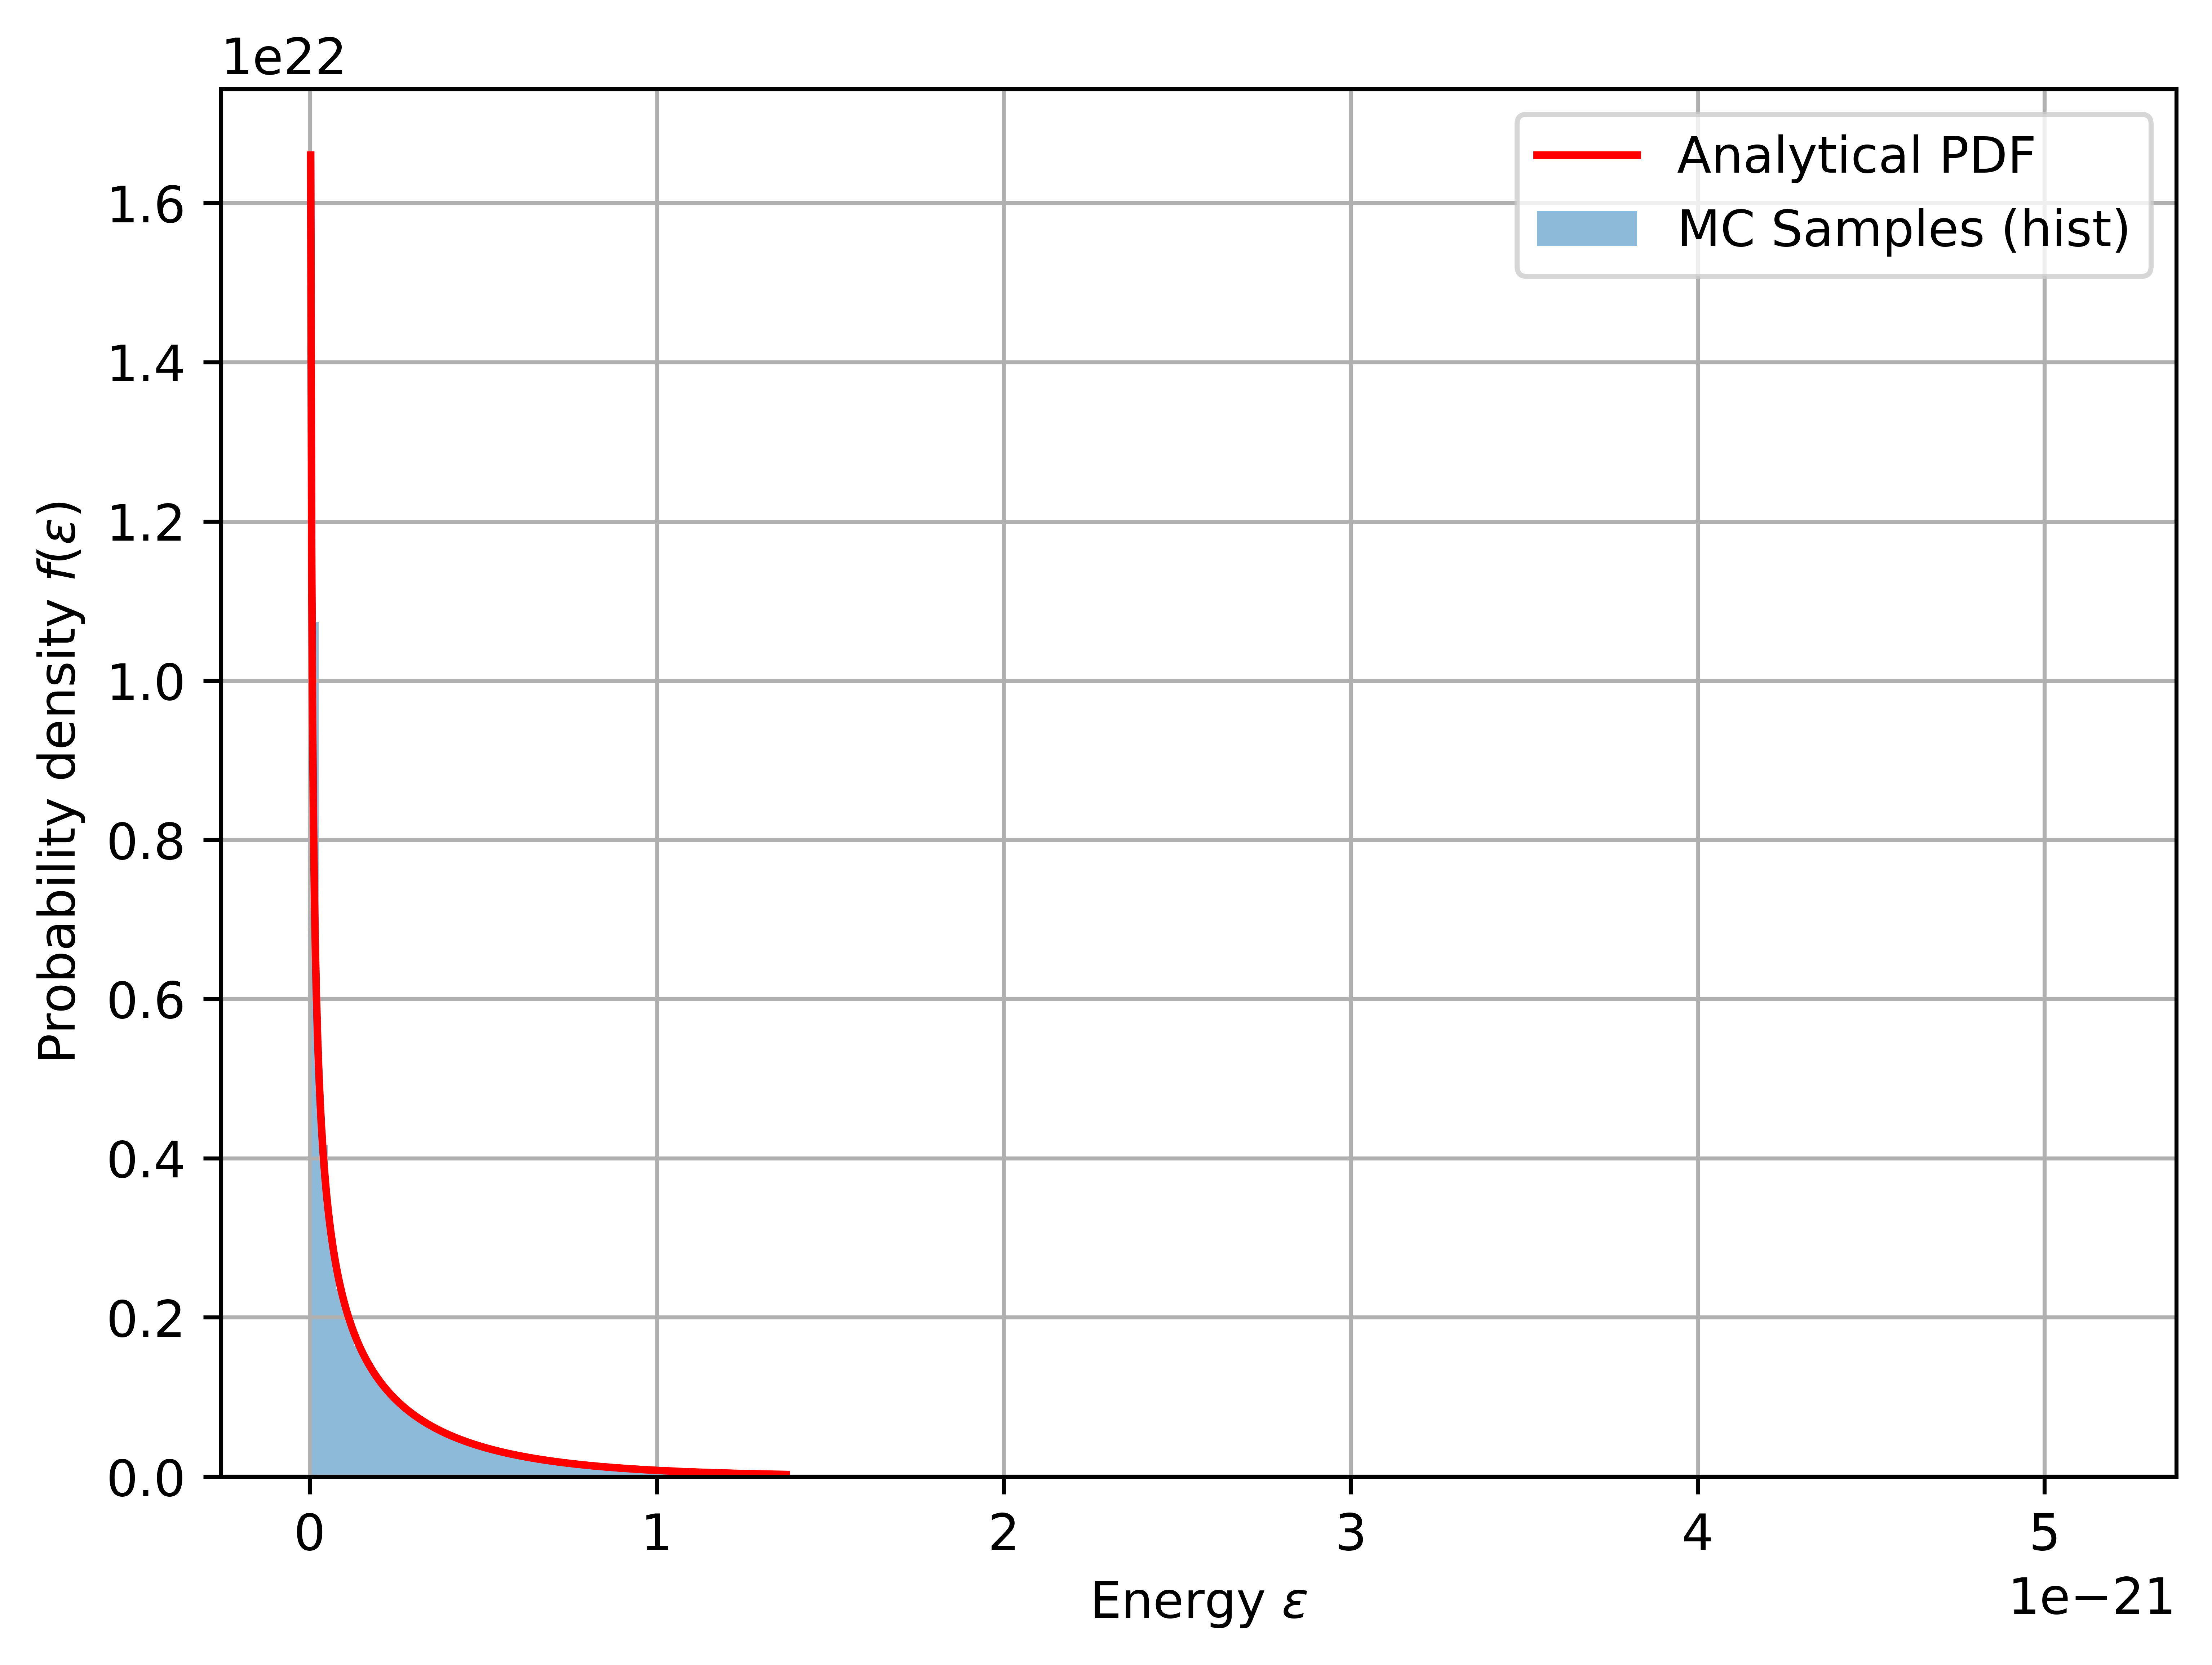

Sample Mean <Ew>: 2.06901e-22 J
Analytical Expectation Value: 2.07090e-22 J
Relative Error: 9.13219e-04


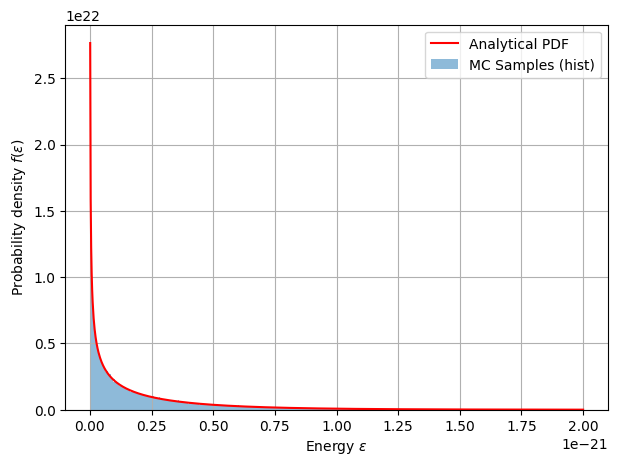

Sample Mean <Ew>: 2.03792e-22 J
Analytical Expectation Value: 2.07090e-22 J
Relative Error: 1.59250e-02
Mean (⟨E⟩): 2.07096e-22 J
Variance: 8.47502e-44 J^2
Skewness: 2.79299
Kurtosis: 14.49943


Mean (⟨E⟩): 2.02734e-22 J
Variance: 7.64681e-44 J^2
Skewness:  2.392452603686982
Kurtosis:  10.033180303623347
The variance of <Ew> is:  1.4041465654348916e-47
The expected variance of <Ew> is sigma^2/N: 


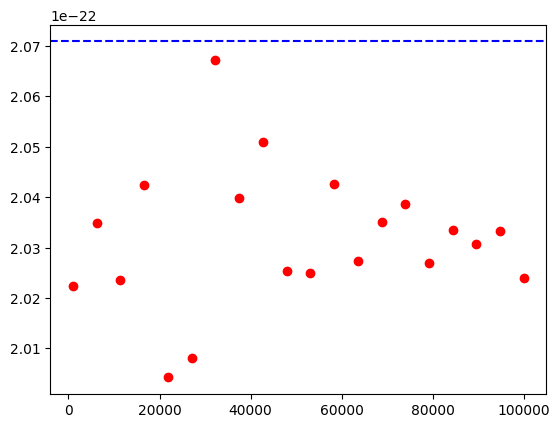

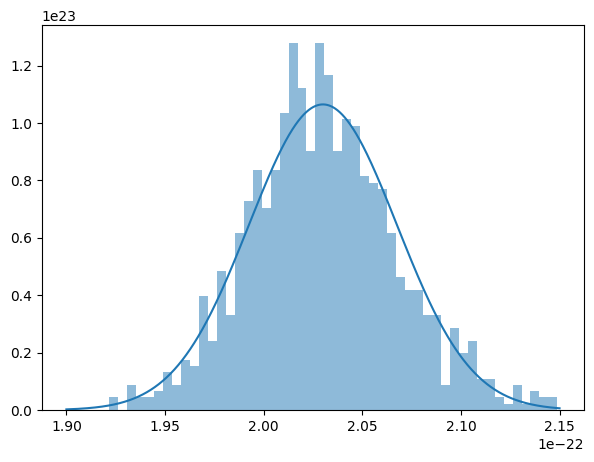

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 20 16:54:47 2024

@author: aidanmcgregor
"""

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import quad
from scipy.special import erfinv
from scipy.stats import skew, kurtosis

m0 = 1.66e-27
K_40_mass = 40*m0 #kg
kb = 1.3806e-23 #J/K
T = 30 #K

beta = 1/(kb*T)

A = np.sqrt(beta/math.pi)


def sample_energy_inverse_transform(N, beta):
    """Generate N samples using the inverse transform method."""
    U = np.random.rand(N)
    return (erfinv(U)**2) / beta

def pdf(eps, beta):
    """Analytical PDF for f(ε) = sqrt(beta/pi) * exp(-beta ε) / sqrt(ε)."""
    import math
    A = np.sqrt(beta / math.pi)
    return A * np.exp(-beta * eps) / np.sqrt(eps)

# --- Main script ---
N = 1000000  # e.g. 1e5 samples

# 1) Generate samples
energy_samples = sample_energy_inverse_transform(N, beta)

# 2) Make a histogram of the samples
bins = 200
hist, bin_edges = np.histogram(energy_samples, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# 3) Plot the histogram versus the analytical PDF
plt.figure(figsize=(7,5), dpi=1000)
plt.bar(bin_centers, hist, width=(bin_edges[1]-bin_edges[0]),
        alpha=0.5, label='MC Samples (hist)')

# Evaluate the PDF on a smooth grid
eps_grid = np.linspace(0, np.percentile(energy_samples, 99.0), 500)
pdf_values = pdf(eps_grid, beta)
plt.plot(eps_grid, pdf_values, 'r-', label='Analytical PDF')

plt.xlabel(r'Energy $\varepsilon$')
plt.ylabel(r'Probability density $f(\varepsilon)$')

plt.legend()
plt.grid(True)
plt.show()

mean_values = np.mean(sample_energy_inverse_transform(N, beta))

analytical_expectation_value = 0.5 * kb * T


print(f"Sample Mean <Ew>: {mean_values:.5e} J")
print(f"Analytical Expectation Value: {analytical_expectation_value:.5e} J")


print(f"Relative Error: {abs(mean_values - analytical_expectation_value) / analytical_expectation_value:.5e}")


def target_pdf(eps, beta):
    """
    Target PDF: f(ε) = sqrt(beta/pi) * exp(-beta ε) / sqrt(ε).
    """
    A = np.sqrt(beta / math.pi)
    return A * np.exp(-beta * eps) / np.sqrt(eps)

def proposal_pdf(eps, lam):
    """
    Proposal PDF: g(ε) = λ / sqrt(ε) * exp(-λ ε).
    """
    return lam * np.exp(-lam * eps) / np.sqrt(eps)


def truncated_gamma(shape, scale, size, upper_bound):
    samples = []
    while len(samples) < size:
        # Generate a sample from the Gamma distribution
        sample = np.random.gamma(shape, scale)
        
        # Accept only samples below the upper bound
        if sample < upper_bound:
            samples.append(sample)
    
    return np.array(samples)

def rejection_sampling(N, beta):
    """
    Monte Carlo rejection sampling for the target PDF f(ε).
    """
    lam = beta  # Set λ = β for better matching
    M = np.sqrt(np.pi / beta)  # Scaling factor ensuring f(ε) <= M * g(ε)
    
    samples = []
    upper_bound = 2e-21
    while len(samples) < N:
        # Sample from the proposal PDF
        eps_proposed = truncated_gamma(0.5,1/lam,1,upper_bound)
        
        # Compute acceptance probability
        accept_prob = target_pdf(eps_proposed, beta) / (M * proposal_pdf(eps_proposed, lam))
        
        # Accept or reject the sample
        if np.random.rand() < accept_prob:
            samples.append(eps_proposed)
    
    return np.array(samples)

# Parameters
N = 100000  # Number of samples

# Generate samples
samples = rejection_sampling(N, beta)

# Plot the results
bins = 500
hist, bin_edges = np.histogram(samples, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

plt.figure(figsize=(7, 5), dpi=100)

# Histogram of samples
plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, label='MC Samples (hist)')

# Analytical target PDF
eps_grid = np.linspace(1e-24, 2e-21, 1000)  # Avoid division by zero by starting slightly above 0
pdf_values = target_pdf(eps_grid, beta)
plt.plot(eps_grid, pdf_values, 'r-', label='Analytical PDF')

# Add labels and legend
plt.xlabel(r'Energy $\varepsilon$')
plt.ylabel(r'Probability density $f(\varepsilon)$')
plt.legend()
plt.grid(True)
plt.show()



mean_samples = np.mean(rejection_sampling(N, beta))
analytical_expectation_value = 0.5 * kb * T


print(f"Sample Mean <Ew>: {mean_samples:.5e} J")
print(f"Analytical Expectation Value: {analytical_expectation_value:.5e} J")


print(f"Relative Error: {abs(mean_samples - analytical_expectation_value) / analytical_expectation_value:.5e}")




N = 100000
beta = 1/(kb*T)
lam = beta

def compute_statistics(samples):
    """Compute mean, variance, skewness, and kurtosis of the energy samples."""
    mean = np.mean(samples)  
    variance = np.var(samples)
    skewness = skew(samples)  
    kurt = kurtosis(samples, fisher=False)  
    
    return mean, variance, skewness, kurt

mean_Inverse, variance_Inverse, skewness_Inverse, kurt_Inverse = compute_statistics(sample_energy_inverse_transform(N, beta))

mean_Neumann, variance_Neumann, skewness_Neumann, kurt_Neumann = compute_statistics(rejection_sampling(N, beta))



print(f"Mean (⟨E⟩): {mean_Inverse:.5e} J")
print(f"Variance: {variance_Inverse:.5e} J^2")
print(f"Skewness: {skewness_Inverse:.5f}")
print(f"Kurtosis: {kurt_Inverse:.5f}\n\n")


print(f"Mean (⟨E⟩): {mean_Neumann:.5e} J")
print(f"Variance: {variance_Neumann:.5e} J^2")
print("Skewness: ", skewness_Neumann[0])
print("Kurtosis: ", kurt_Neumann[0])


#Law of large number to check convergence

LLN_y = []
for n in range(20):
    LLN_x = np.linspace(1000, 100000, 20)
    LLN_y.append(np.mean(rejection_sampling(LLN_x[n], beta)))

plt.plot(LLN_x,LLN_y, 'ro', label='Mean for different sample sizes')
plt.axhline(y=2.07090e-22, color='b', linestyle='--', label='Theoretical Mean')
   
 
#Central Limit theorem to check normal distrbution line shape 

CLT_means = []

for n in range(1000):
    CLT_means.append(np.mean(rejection_sampling(5000, beta)))

hist, bin_edges = np.histogram(CLT_means, bins=50, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

plt.figure(figsize=(7, 5), dpi=100)

# Histogram of samples
plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, label='MC Samples (hist)')


CLT_av = np.mean(CLT_means)
CLT_var = np.var(CLT_means)

CLT_x = np.linspace(1.9e-22,2.15e-22, 1000)
CLT_y = 1/np.sqrt(2*CLT_var*np.pi) *np.exp(-((CLT_x-CLT_av)**2)/(2*CLT_var))

plt.plot(CLT_x, CLT_y)


print("The variance of <Ew> is: ", CLT_var)
print("The expected variance of <Ew> is sigma^2/N: ", )








